In [5]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import string
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [42]:
from collections import defaultdict

# Try to pull all Friday releases for movies in April 2016
url = 'http://www.imdb.com/movies-coming-soon/2016-04'
response = requests.get(url)
while(not response.ok):
    response = requests.get(url)

page = response.text
soup = BeautifulSoup(page,'lxml')

# Pulling upcoming movies from IMDB
release_dict = defaultdict(list)
for item in soup.find_all('h4'):
    item = item.find('a').text
    if(item[0] != " "):
        value = item.strip()
    else:
        name = item.split('(')[0].strip()
        release_dict[name].append(value)
        release_dict[name].append(item.split('(')[1].replace(')',''))
        
release_dict = pd.DataFrame.from_dict(release_dict,orient='index')
release_dict = release_dict.reset_index()
release_dict.columns = ['Title','Date','Year']
release_dict

,Title,Date,Year
0,Compadres,April 22,2016
1,Un tango más,April 15,2015
2,Sing Street,April 15,2016
3,Hardcore Henry,April 8,2015
4,Elvis & Nixon,April 22,2016
5,Green Room,April 15,2015
6,Mother's Day,April 29,2016
7,The Dying of the Light,April 8,2015
8,The Boss,April 8,2016
9,Louder Than Bombs,April 8,2015


In [43]:
# Pull opening weekend revenue for 2015
url = 'http://www.boxofficemojo.com/yearly/chart/?yr=2015&p=.htm'
response = requests.get(url)
while(not response.ok):
    respone = requests.get(url)
    
page = response.text
soup = BeautifulSoup(page,'lxml')

In [6]:
def remove_punctuation(x):
    x = str(x)
    return x.translate(str.maketrans({a:None for a in string.punctuation}))

In [7]:
def scrape_opening_weekend(year=2015):
    url = 'http://www.boxofficemojo.com/yearly/chart/?yr='+str(year)+'&p=.htm'
    response = requests.get(url)
    while(not response.ok):
        response = requests.get(url)

    page = response.text
    soup = BeautifulSoup(page,'lxml')
    
    # Find number of pages on table for the year
    item = soup.find('center')
    pages = len(item.find_all('a'))+1
    
    # Pull table from each page
    for i in range(1,pages+1):
        url = 'http://www.boxofficemojo.com/yearly/chart/?page='+str(i)+'&view=releasedate&view2=domestic&yr='+str(year)+'&sort=opengross&p=.htm'
        tables = pd.read_html(url)
        table = tables[2]
        table = table.iloc[6:-6,2:9]
        table.columns = ['title','studio','total_gross','total_theatres','opening','opening_theatres','release_date']
        if i==1:
            df = table
        else:
            df = pd.concat([df,table])
            
    # Clean up dataframe types
    df.release_date = pd.to_datetime(df.release_date+str(year),format='%m/%d%Y')
    df = df.dropna(subset=['opening','opening_theatres'])
    df.total_gross = df.total_gross.map(lambda x: int(remove_punctuation(x)))
    df.total_theatres = df.total_theatres.map(lambda x: int(x))
    df.opening = df.opening.map(lambda x: int(remove_punctuation(x)))
    df.opening_theatres = df.opening_theatres.map(lambda x: int(x))
    return df
        

In [8]:
data = scrape_opening_weekend()

In [61]:
data.head()

,title,studio,total_gross,total_theatres,opening,opening_theatres,release_date,release_month
6,Star Wars: The Force Awakens,BV,"$935,910,912",4134,247966675,4134,2015-12-18,12
7,Jurassic World,Uni.,"$652,270,625",4291,208806270,4274,2015-06-12,6
8,Avengers: Age of Ultron,BV,"$459,005,868",4276,191271109,4276,2015-05-01,5
9,Furious 7,Uni.,"$353,007,020",4022,147187040,4004,2015-04-03,4
10,Minions,Uni.,"$336,045,770",4311,115718405,4301,2015-07-10,7


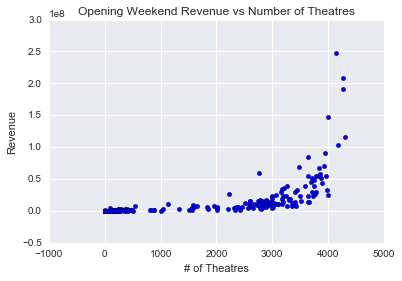

In [82]:
plt.scatter(data.opening_theatres, data.opening)
plt.title('Opening Weekend Revenue vs Number of Theatres')
plt.ylabel('Revenue')
plt.xlabel('# of Theatres')

In [74]:
import numpy as np
import statsmodels.formula.api as sm

In [75]:
model = sm.ols('opening ~ np.power(opening_theatres,2) + opening_theatres', data=data)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                opening   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     525.6
Date:                Mon, 25 Apr 2016   Prob (F-statistic):          3.81e-134
Time:                        13:03:41   Log-Likelihood:                -11040.
No. Observations:                 622   AIC:                         2.209e+04
Df Residuals:                     619   BIC:                         2.210e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                      1.186e+06   5.71e+05      2.076      0.038       6.4e+04  2.31e+06
np.power(opening_theatres, 2)    11.0200      0.588     18.730      0.000         9.865    12.175
opening_theatres              -2.626e+04   2022.109    -12.987      0.000     -3.02e+04 -2.23e+04
==============================================================================
Omnibus:                      802.176   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           151093.906
Skew:                           6.343   Prob(JB):                         0.00
Kurtosis:                      78.293   Cond. No.                     5.25e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
test = scrape_opening_weekend(2016)

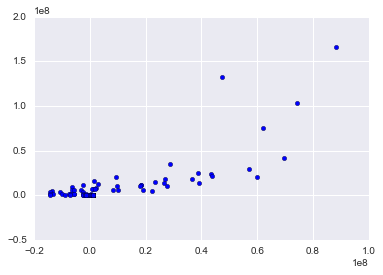

In [84]:
plt.scatter(fit.predict(test),test.opening)

In [9]:
data.to_pickle('2015.pkl')

In [57]:
data['release_month'] = data.release_date.map(lambda x: x.month)

In [60]:
sns.pairplot(data[['opening','opening_theatres','release_month']])

//anaconda/lib/python3.5/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


In [ ]:
#helping rafa
url = 'http://www.boxofficemojo.com/search/?q=x-men:%20the%20last%20stand'
response = requests.get(url)
soup = BeautifulSoup(response.text,'lxml')

In [ ]:
soup.find_all('b')[1].find('a').get('href')

In [ ]:
soup.find('tr',attrs={'bgcolor':'#FFFF99'}).find('a').get('href')

In [ ]:
# helping anny
for year in range(1982,2017):
    url = 'http://www.boxofficemojo.com/monthly/?view=calendargross&chart=byyear&yr='+str(year)+'&view=calendargross'
    tables = pd.read_html(url,header=0)
    table = tables[2]
    table = table.iloc[:-1,:]
    table['year'] = year
    if year == 1982:
        df = table
    else:
        df = pd.concat([df, table])